In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn_pandas

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


In [2]:
# Importing libraries 
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import feature_selection
from sklearn.impute import SimpleImputer
import sklearn_pandas

In [3]:
df_job=pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
df_job.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


# EDA

In [4]:
df_job['function'].value_counts()
stem = ['Information Technology', 'Engineering', 'Data Analyst', 'Science', 'Business Analyst', 'Quality Assurance']
non_stem = ['Sales', 'Customer Service', 'Marketing', 'Administrative', 'Design', 'Human Resources']
df_stem = df_job[df_job['function'].isin(stem)]
df_non_stem = df_job[df_job['function'].isin(non_stem)]
print(df_stem.shape)
print(df_non_stem.shape)

df_non_stem['fraudulent'].value_counts()

(3388, 18)
(4702, 18)


0    4453
1     249
Name: fraudulent, dtype: int64

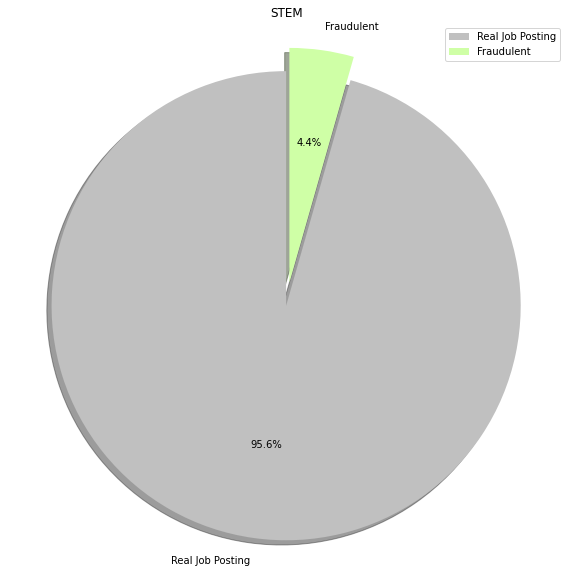

In [5]:
import matplotlib.pyplot as plt

stem_zero = df_stem['fraudulent'].value_counts()[0]
stem_one = df_stem['fraudulent'].value_counts()[1]
non_stem_zero = df_non_stem['fraudulent'].value_counts()[0]
non_stem_one = df_non_stem['fraudulent'].value_counts()[1]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Real Job Posting', 'Fraudulent'
sizes = [stem_zero, stem_one]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

#add colors
colors = ['#C0C0C0','#CFFFA6']

fig1, ax1 = plt.subplots(figsize = (10, 10))
ax1.pie(sizes, explode=explode, colors=colors, labels = labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('STEM')
plt.legend()
plt.show()

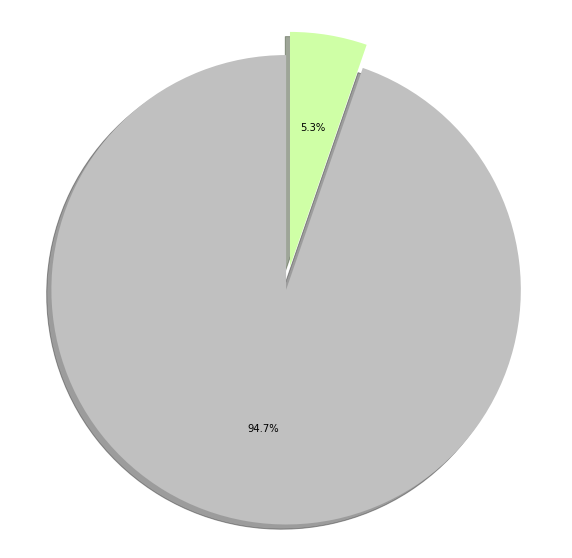

In [6]:
labels = 'Real Job Posting', 'Fraudulent'
sizes_non_stem = [non_stem_zero, non_stem_one]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize = (10, 10))
ax1.pie(sizes_non_stem, explode=explode, colors = colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [7]:
df_real = df_job.loc[df_job['fraudulent']==0]
df_fake = df_job.loc[df_job['fraudulent']==1]
df_real['description'] = df_real['description'].astype('str')
df_fake['description'] = df_fake['description'].astype('str')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


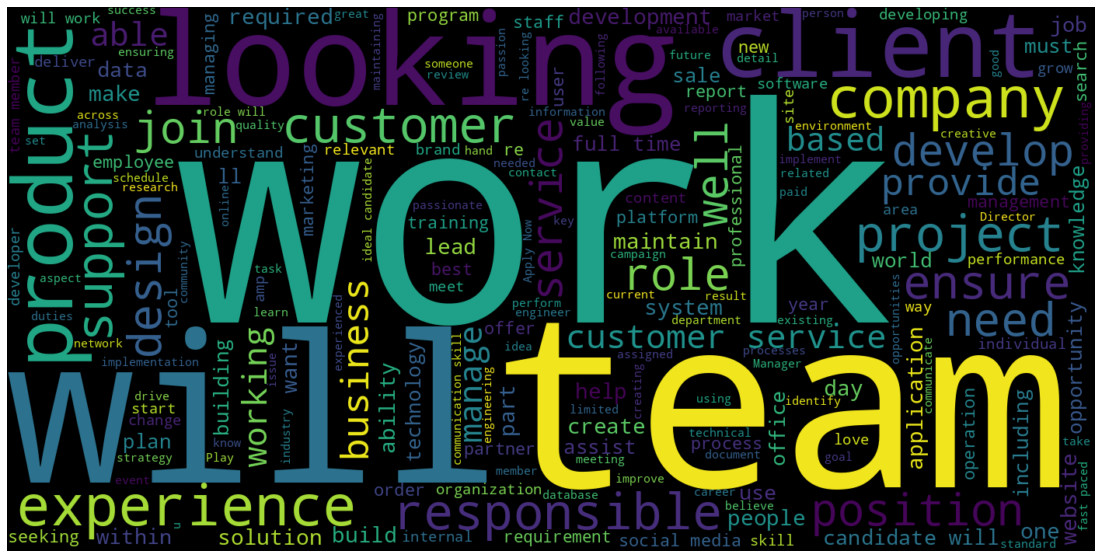

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

target_text = " ".join(df_real['description'])
wordcloud = WordCloud(width=1400, height=700).generate(text=target_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

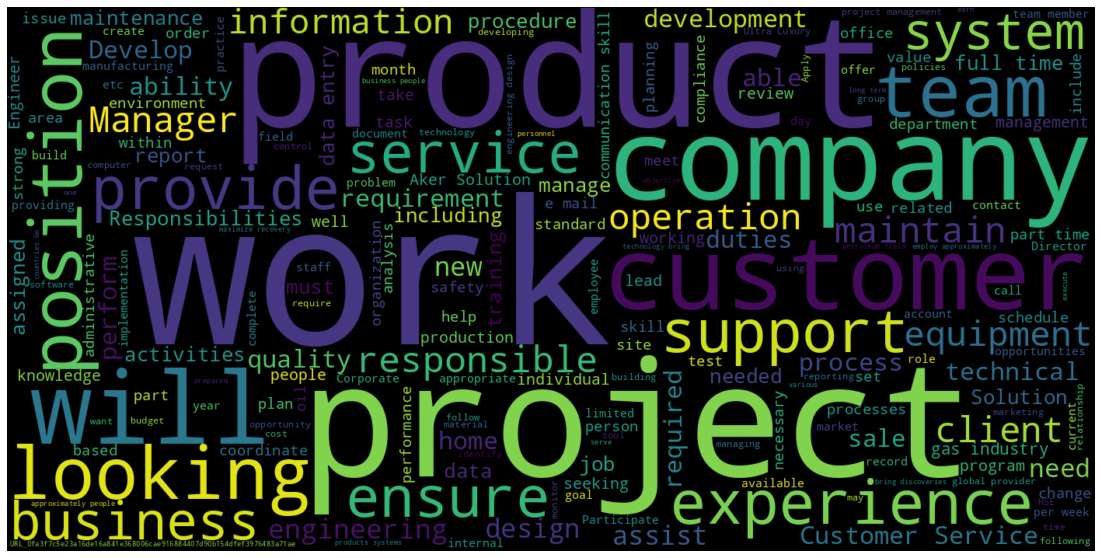

In [9]:
target_text = " ".join(df_fake['description'])
wordcloud = WordCloud(width=1400, height=700).generate(text = target_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Data Cleaning

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import feature_selection
from sklearn.impute import SimpleImputer

df_job['department'] = df_job['department'].fillna(df_job['department'].mode()[0])

data_cat_imp=SimpleImputer(strategy="constant",fill_value="Missing")
cat_imp_feature=["title","location","department","salary_range","company_profile","description","requirements","benefits",
                 "employment_type","required_experience","required_education","industry","function"]

# Filling the Numerical values through existing value
data_num_imp=SimpleImputer(strategy="constant",fill_value=None)
num_imp_feature =["job_id","telecommuting","has_company_logo","has_questions","fraudulent"]

# Transforming into column
data_imp_trans=ColumnTransformer([("data_cat_imp",data_cat_imp,cat_imp_feature),
                                 ("data_num_imp",data_num_imp,num_imp_feature)])

# Transforming and assigning the data
transformed_data=data_imp_trans.fit_transform(df_job)
transformed_data

#Transforming the data into data frame
df_job_transformed_data=pd.DataFrame(transformed_data,
                         columns=["title","location","department","salary_range","company_profile","description",
                                  "requirements","benefits", "employment_type","required_experience","required_education",
                                  "industry","function","job_id","telecommuting","has_company_logo","has_questions",
                                  "fraudulent"])

X_trans = df_job_transformed_data.drop("fraudulent",axis=1)
y_trans = df_job_transformed_data.fraudulent
y_trans=y_trans.astype('int')

X_trans.shape, y_trans.shape,X_trans.columns

# Instantation of One Hot Encoder for categorical data tarnsformatio into Numeric 
one_hot=OneHotEncoder()
clf_trans=ColumnTransformer([("one_hot",one_hot,cat_imp_feature)],remainder="passthrough")
X_trans_fin=clf_trans.fit_transform(X_trans)
np.array(X_trans_fin)

X_train,X_test,y_train,y_test=train_test_split(X_trans_fin,y_trans,test_size=0.25, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((13410, 51438), (4470, 51438), (13410,), (4470,))

# Modeling: 
### Random Forest, Decision Tree, Logistic Regression, Neural Network MLP

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Random forest
model_rfm=RandomForestClassifier(random_state=42)
model_rfm.fit(X_train,y_train)
y_pred_rfm = model_rfm.predict(X_test)
rfc_accuracy = model_rfm.score(X_test, y_test)

# Decision Tree
model_dtc = DecisionTreeClassifier(random_state=42)
model_dtc.fit(X_train, y_train)
y_pred_dtc = model_dtc.predict(X_test)
dtc_accuracy = model_dtc.score(X_test, y_test)

# Logistic regression
model_logreg = LogisticRegression(solver='newton-cg', random_state=42)
model_logreg.fit(X_train, y_train)
y_prob = model_logreg.predict_proba(X_test)
Y_pred = pd.Series([1 if x > 0.5 else 0 for x in y_prob[:,1]], index = y_test.index)
lg_accuracy = model_logreg.score(X_test, y_test)

# Neural Network
clf = MLPClassifier(hidden_layer_sizes=(10,10,10,), max_iter=100,
                     activation='logistic', solver='lbfgs', learning_rate='constant', verbose=1,  random_state=42)  
clf.fit(X_train,y_train)
y_pred_test = clf.predict(X_test)
nn_accuracy = accuracy_score(y_pred_test,y_test)

print("Random Forest accuracy", rfc_accuracy)
print("Decision Tree accuracy", dtc_accuracy)
print("Logistic Regression accuracy", lg_accuracy)
print("Neural Network accuracy", nn_accuracy)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       514621     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49197D-01    |proj g|=  2.93490D-01

At iterate    1    f=  1.96522D-01    |proj g|=  2.17900D-02

At iterate    2    f=  1.93596D-01    |proj g|=  1.09860D-02


 This problem is unconstrained.



At iterate    3    f=  1.92450D-01    |proj g|=  1.02027D-03

At iterate    4    f=  1.92438D-01    |proj g|=  1.99842D-04

At iterate    5    f=  1.92438D-01    |proj g|=  1.45826D-04

At iterate    6    f=  1.92437D-01    |proj g|=  8.01003D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****      6      7      1     0     0   8.010D-05   1.924D-01
  F =  0.19243728646348879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Random Forest accuracy 0.983668903803132
Decision Tree accuracy 0.9885906040268456
Logistic Regression accuracy 0.9816554809843401
Neural Network accuracy 0.9501118568232663


# Models ordered by Accuracy

<BarContainer object of 4 artists>

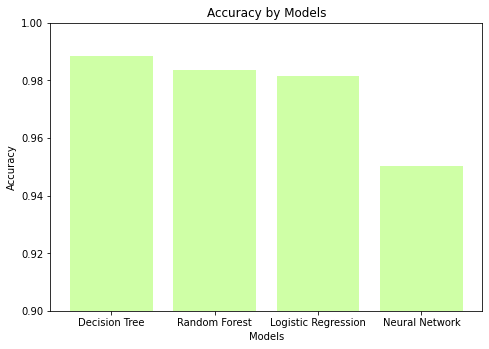

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()

c = ['#CFFFA6']

ax = fig.add_axes([0,0,1,1])
models = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Neural Network']
accuracy = [dtc_accuracy,rfc_accuracy, lg_accuracy,nn_accuracy]
ax.bar(models,accuracy)
ax.set_ylim([0.9, 1])
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Models')
plt.bar(models, height = accuracy, color = c)

# Feature Importance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


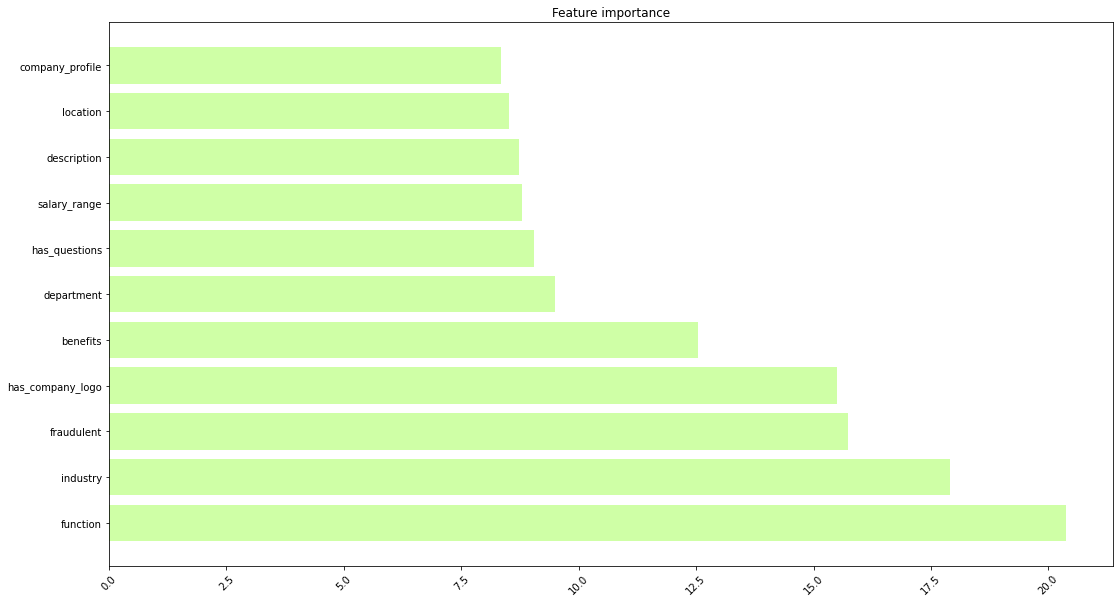

In [13]:
feature_dict=dict(zip((df_job.columns),list(model_rfm.feature_importances_)))

log_val = []
for i in feature_dict.values():
    log_val.append(np.log(i))

log_val = np.nan_to_num(log_val, neginf=0)
log_val = [i * (-1) for i in log_val]
names = list(feature_dict.keys())
dictionary = dict(zip(names, log_val))

sorted_dict = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse = True))
names = []
values = []

for k, v in sorted_dict.items():
    if v != -0.0:
        names.append(k)
        values.append(v)
        
plt.figure(figsize = (18, 10))
colors = ['#CFFFA6']
plt.barh(range(len(values)), values, tick_label=names, color = colors[0])
plt.xticks(rotation=45)
plt.title('Feature importance')
plt.show()